In [10]:
# Import necessary libraries
import os
import boto3
from io import StringIO
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [11]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Set directories
output_dir = "../data/outputs/"
report_dir = "reports/"

# Create reports directory if it doesn't exist
os.makedirs(report_dir, exist_ok=True)

# Define report file paths
evaluation_file = os.path.join(report_dir, "evaluation_summary.csv")
benchmark_file = os.path.join(report_dir, "benchmarks.csv")

# Get current date
current_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Define model prediction files
model_predictions = {
    "Logistic Regression": os.path.join(output_dir, "lr_model_predictions.csv"),
    "Random Forest": os.path.join(output_dir, "rf_model_predictions.csv"),
    "XGBoost": os.path.join(output_dir, "xgboost_model_predictions.csv"),
}

In [12]:
# Initialize a list to store results
evaluation_results = []

# ---- STEP 1: CALCULATE METRICS FOR EACH MODEL ----
for model_name, file_path in model_predictions.items():
    if os.path.exists(file_path):  # Check if predictions file exists
        # Read predictions
        df = pd.read_csv(file_path)
        y_true = df["Actual"]
        y_pred = df["Predicted"]
        y_pred_proba = df["Predicted_Probability"]

        # Compute metrics
        metrics = {
            "Timestamp": current_date,
            "Model": model_name,
            #"Data": os.path.basename(file_path),
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred),
            "F1 Score": f1_score(y_true, y_pred),
            "AUC-ROC": roc_auc_score(y_true, y_pred_proba),
        }

        # Append to results list
        evaluation_results.append(metrics)

# Convert results to DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

In [13]:
# ---- STEP 2: SAVE EVALUATION SUMMARY ----
evaluation_df.to_csv(evaluation_file, index=False)
print(f"Evaluation Summary Saved at: {evaluation_file}")

Evaluation Summary Saved at: reports/evaluation_summary.csv


In [14]:
# ---- STEP 3: IDENTIFY BEST MODEL BASED ON F1-SCORE ----
best_model = evaluation_df.sort_values(by="F1 Score", ascending=False).iloc[0]

In [15]:
# ---- STEP 4: UPDATE BENCHMARKS ----
if os.path.exists(benchmark_file):
    benchmarks_df = pd.read_csv(benchmark_file)
    benchmarks_df = pd.concat([benchmarks_df, best_model.to_frame().T], ignore_index=True)
else:
    benchmarks_df = pd.DataFrame([best_model])

In [16]:
# Save benchmark file
benchmarks_df.to_csv(benchmark_file, index=False)
print(f"Benchmark Updated at: {benchmark_file}")

Benchmark Updated at: reports/benchmarks.csv


In [17]:
# Define S3 bucket and file details
bucket_name = "refocus-storage"
file_key = "benchmarks/benchmarks.csv"

# Convert DataFrame to CSV format in memory
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

# Create S3 client
s3 = boto3.client("s3")

# Upload CSV file to S3
s3.put_object(Bucket=bucket_name, Key=file_key, Body=csv_buffer.getvalue())

print(f"File successfully uploaded to s3://{bucket_name}/{file_key}")

File successfully uploaded to s3://refocus-storage/benchmarks/benchmarks.csv


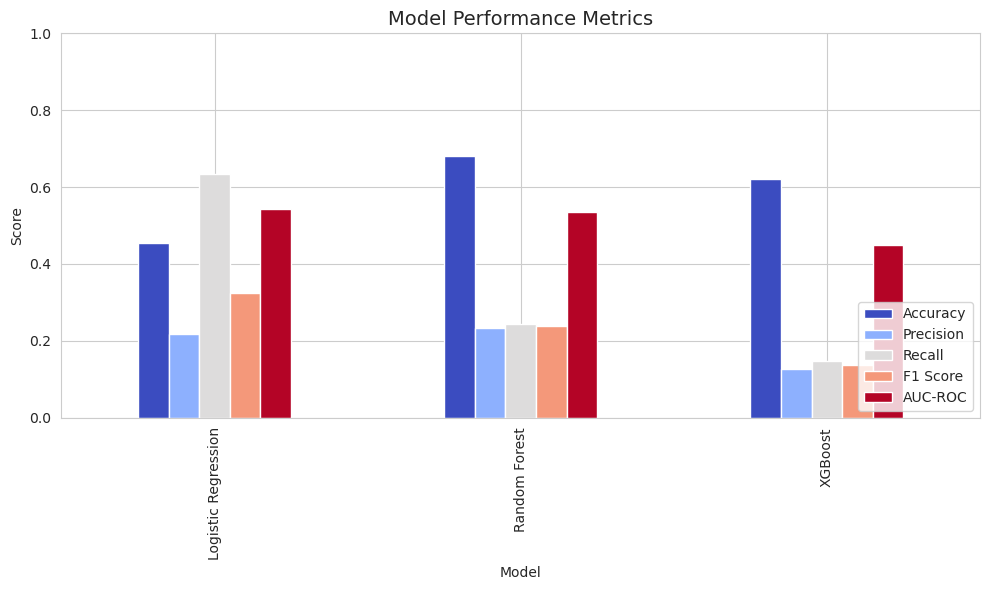

In [18]:
# ---- STEP 5: VISUALIZE MODEL PERFORMANCE ----
# Set style
sns.set_style("whitegrid")

# Plot comparison of metrics (without highlighting best model)
fig, ax = plt.subplots(figsize=(10, 6))
evaluation_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"]].plot(kind="bar", ax=ax, colormap="coolwarm")

ax.set_title("Model Performance Metrics", fontsize=14)
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(loc="lower right")

# Show plots
plt.tight_layout()
plt.show()